In [2]:
import numpy as np
import os

import pandas as pd

%matplotlib inline
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import (
    KFold, StratifiedKFold, train_test_split)
from sklearn.feature_selection import RFECV

from sklearn.svm import SVC

import joblib

from libs.container import Container
import dataset

In [20]:
df

,Tile A,Tile B,Prec.,Recall,AUC
0,b206,b214,0.999001,1.0000,1.000000
1,b206,b216,0.993468,0.9125,0.987967
2,b206,b220,0.995729,0.9325,0.988681
3,b206,b228,0.999001,1.0000,1.000000
4,b206,b234,0.998982,0.9815,0.999560
...,...,...,...,...,...
115,b277,b360,0.994955,0.9860,0.999593
116,b277,b396,0.704934,0.7430,0.769270
117,b278,b360,0.997997,0.9965,0.999945
118,b278,b396,0.832402,0.8195,0.899133


In [21]:
df = joblib.load("results/all_vs_all_table.pkl.bz2")
df.columns = ['Tile A', 'Tile B', 'Precision', 'Recall', 'AUC']
df.head()

,Tile A,Tile B,Precision,Recall,AUC
0,b206,b214,0.999001,1.0000,1.000000
1,b206,b216,0.993468,0.9125,0.987967
2,b206,b220,0.995729,0.9325,0.988681
3,b206,b228,0.999001,1.0000,1.000000
4,b206,b234,0.998982,0.9815,0.999560


In [22]:
from scipy.spatial import distance

POSITIONS = {
    "b206": (13, 8),
    "b214": (13, 0),
    "b216": (12, 12),
    'b220': (12, 8),
    "b228": (12, 0),
    'b234': (11, 8),
    'b247': (10, 9),
    'b248': (10, 8),
    'b261': ( 9, 9),
    'b262': ( 9, 8),
    'b263': ( 9, 7),
    'b264': ( 9, 6),
    'b277': ( 8, 7),
    'b278': ( 8, 6),
    "b360": (2, 8),
    'b396': ( 0, 0),
}

def get_dis(row):
    ta, tb = (row["Tile A"], row["Tile B"])
    pa = list(map(float, POSITIONS[ta]))
    pb = list(map(float, POSITIONS[tb]))
    return distance.cityblock(pa, pb)

df["Distance"] = df.apply(get_dis, axis=1)
df.head()

,Tile A,Tile B,Precision,Recall,AUC,Distance
0,b206,b214,0.999001,1.0000,1.000000,8.0
1,b206,b216,0.993468,0.9125,0.987967,5.0
2,b206,b220,0.995729,0.9325,0.988681,1.0
3,b206,b228,0.999001,1.0000,1.000000,9.0
4,b206,b234,0.998982,0.9815,0.999560,2.0


In [23]:
from collections import Counter
all_tiles = list(set(list(df["Tile A"].values) + list(df["Tile B"].values)))
all_tiles

freq = dict(Counter(df["Tile A"].values).most_common())
for t in all_tiles:
    if t not in freq:
        freq[t] = (max(freq.values()) + 100) * -1

In [24]:
all_tiles = sorted(all_tiles, key=freq.get)
all_tiles

['b396',
 'b360',
 'b278',
 'b277',
 'b264',
 'b263',
 'b262',
 'b261',
 'b248',
 'b247',
 'b234',
 'b228',
 'b220',
 'b216',
 'b214',
 'b206']

In [11]:
def table(attr, use_distance=False):
    print(attr)
    rows = []
    for ta in all_tiles:
        row = [ta]
        for tb in all_tiles:
            pa, pb = POSITIONS[ta], POSITIONS[tb]
            d = distance.cityblock(pa, pb) if use_distance else 1
            try:
                flt = (df["Tile A"] == ta) & (df["Tile B"] == tb)
                v = df[flt][attr].values[0] * d
            except:
                v = np.nan
            row.append(v)
        if len(set(row)) != 2:
            rows.append(row)
    tab = pd.DataFrame(rows, columns=["Tile A"] + all_tiles).set_index("Tile A")
    tab = tab.dropna(axis=1, how='all')
    return tab

In [17]:
table("Prec.")

,b396,b360,b278,b277,b264,b263,b262,b261,b248,b247,b234,b228,b220,b216,b214
Tile A,,,,,,,,,,,,,,,
b360,0.986967,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
b278,0.832402,0.997997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
b277,0.704934,0.994955,0.738587,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
b264,0.938246,0.999001,0.862785,0.927264,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
b263,0.911933,0.999001,0.878700,0.915183,0.663438,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
b262,0.853708,1.000000,0.726735,0.822233,0.777390,0.683768,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
b261,0.969214,1.000000,0.880042,0.959000,0.674077,0.781855,0.796849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
b248,0.989458,1.000000,0.969223,0.996500,0.799799,0.887097,0.913303,0.793819,NaN,NaN,NaN,NaN,NaN,NaN,NaN
b247,0.996496,1.000000,0.981555,1.000000,0.849259,0.928535,0.946226,0.861381,0.644048,NaN,NaN,NaN,NaN,NaN,NaN


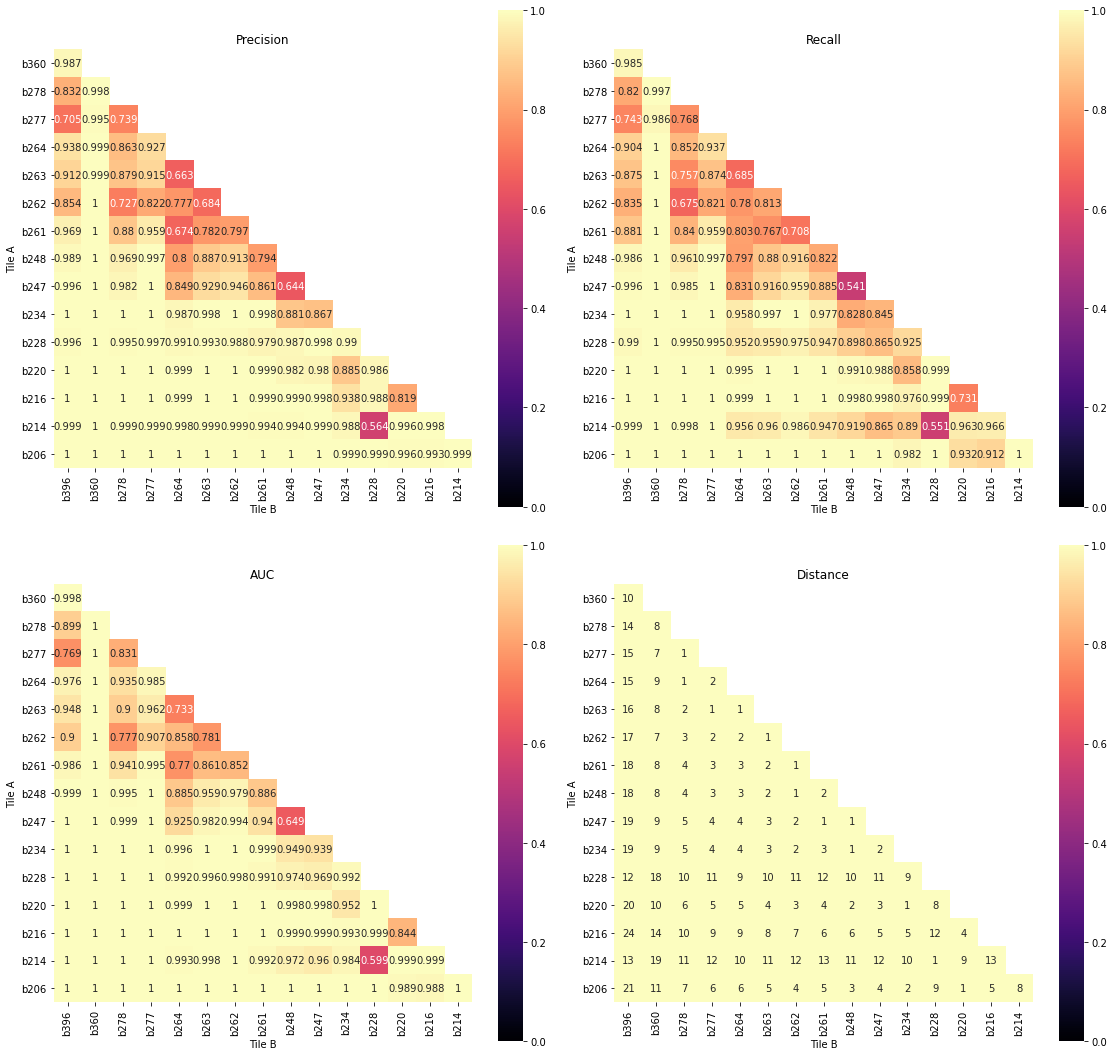

In [32]:
fig, axes = plt.subplots(2,2, figsize=(16, 15))

kwargs = dict(square=True, fmt=".3g", annot=True, cmap="magma", vmin=0, vmax=1, center=.5)

ax, name = axes[0][0], "Precision"
sns.heatmap(table(name), ax=ax, **kwargs)
ax.set_title(name)
ax.set_xlabel("Tile B")

ax, name = axes[0][1], "Recall"
sns.heatmap(table(name), ax=ax, **kwargs)
ax.set_title(name)
ax.set_xlabel("Tile B")

ax, name = axes[1][0], "AUC"
sns.heatmap(table(name), ax=ax, **kwargs)
ax.set_title(name)
ax.set_xlabel("Tile B")

ax, name = axes[1][1], "Distance"
sns.heatmap(table(name), ax=ax, **kwargs)
ax.set_title(name)
ax.set_xlabel("Tile B")


plt.tight_layout()
plt.savefig("plots/all_vs_all.pdf")

plt.show()

In [95]:
from collections import Counter

md = df.groupby("Distance").median()
freq = Counter(df.Distance.values)

def get_freq(r):
    return freq[r.name]
    
md["Count"] = md.apply(get_freq, axis=1)

Distance
1.0     13
2.0     12
3.0     11
4.0     11
5.0      9
6.0      5
7.0      4
8.0      7
9.0      9
10.0     8
11.0     7
12.0     6
13.0     3
14.0     2
15.0     2
16.0     1
17.0     1
18.0     3
19.0     3
20.0     1
21.0     1
24.0     1
dtype: int64

In [98]:
print(md[md.Count >= 5].to_latex(float_format="%.3f"))

\begin{tabular}{lrrrr}
\toprule
{} &  Precision &  Recall &   AUC &  Count \\
Distance &            &         &       &        \\
\midrule
1.0      &      0.861 &   0.828 & 0.935 &     13 \\
2.0      &      0.883 &   0.862 & 0.949 &     12 \\
3.0      &      0.980 &   0.977 & 0.998 &     11 \\
4.0      &      0.999 &   1.000 & 1.000 &     11 \\
5.0      &      0.999 &   0.998 & 0.999 &      9 \\
6.0      &      1.000 &   1.000 & 1.000 &      5 \\
8.0      &      0.999 &   1.000 & 1.000 &      7 \\
9.0      &      0.999 &   1.000 & 1.000 &      9 \\
10.0     &      0.994 &   0.972 & 0.997 &      8 \\
11.0     &      0.998 &   0.975 & 0.998 &      7 \\
12.0     &      0.997 &   0.988 & 0.999 &      6 \\
\bottomrule
\end{tabular}

